[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

In [1]:
import torch
import torchvision


In [2]:
# import zipfile

# with zipfile.ZipFile('D:/Laboratorios/datasets/basura.zip', 'r') as zip_ref:
#     zip_ref.extractall('D:/Laboratorios/datasets/basura/')

In [3]:
import os

PATH = 'D:/Laboratorios/datasets/basura/garbage_classification'

classes = os.listdir(PATH)
classes

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [4]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: battery. Imágenes: 945
Categoría: biological. Imágenes: 985
Categoría: brown-glass. Imágenes: 607
Categoría: cardboard. Imágenes: 891
Categoría: clothes. Imágenes: 5325
Categoría: green-glass. Imágenes: 629
Categoría: metal. Imágenes: 769
Categoría: paper. Imágenes: 1050
Categoría: plastic. Imágenes: 865
Categoría: shoes. Imágenes: 1977
Categoría: trash. Imágenes: 697
Categoría: white-glass. Imágenes: 775


In [5]:
imgs[:12]
len(imgs)

15515

Podemos visualizar algunas imágenes en el dataset.

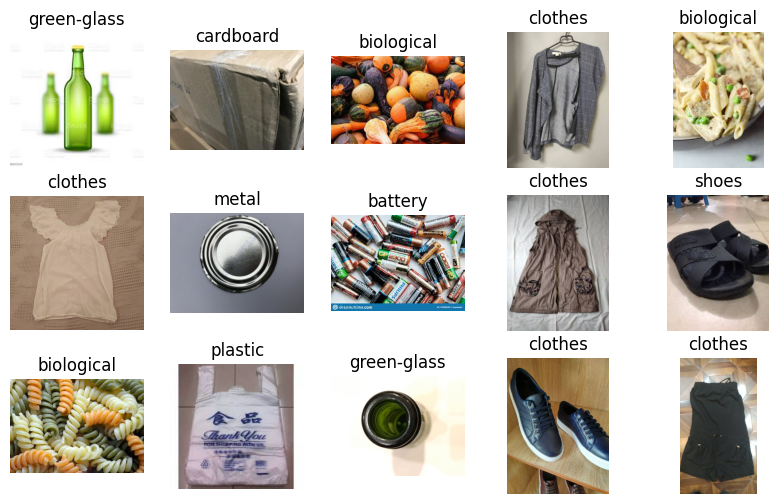

In [6]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [7]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(12412, 3103)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [8]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [9]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(12412, 3103)

In [10]:
dataset['train'][2]

(tensor([[[0.1529, 0.1059, 0.0980,  ..., 0.0980, 0.1294, 0.1647],
          [0.1490, 0.1294, 0.0941,  ..., 0.1059, 0.1412, 0.1922],
          [0.1608, 0.1216, 0.0980,  ..., 0.0980, 0.1412, 0.1961],
          ...,
          [0.1020, 0.1176, 0.1333,  ..., 0.4667, 0.4667, 0.4588],
          [0.1059, 0.1137, 0.1255,  ..., 0.4588, 0.4588, 0.4588],
          [0.1020, 0.1098, 0.0941,  ..., 0.4588, 0.4549, 0.4588]],
 
         [[0.1451, 0.0980, 0.0902,  ..., 0.0902, 0.1216, 0.1569],
          [0.1412, 0.1216, 0.0902,  ..., 0.0980, 0.1333, 0.1843],
          [0.1529, 0.1137, 0.0902,  ..., 0.0902, 0.1333, 0.1882],
          ...,
          [0.0941, 0.1098, 0.1255,  ..., 0.4157, 0.4157, 0.4078],
          [0.0980, 0.1059, 0.1176,  ..., 0.4118, 0.4078, 0.4078],
          [0.0941, 0.1020, 0.0863,  ..., 0.4078, 0.4039, 0.4078]],
 
         [[0.1529, 0.1020, 0.0941,  ..., 0.0941, 0.1255, 0.1608],
          [0.1451, 0.1255, 0.0902,  ..., 0.1020, 0.1373, 0.1882],
          [0.1569, 0.1176, 0.0941,  ...,

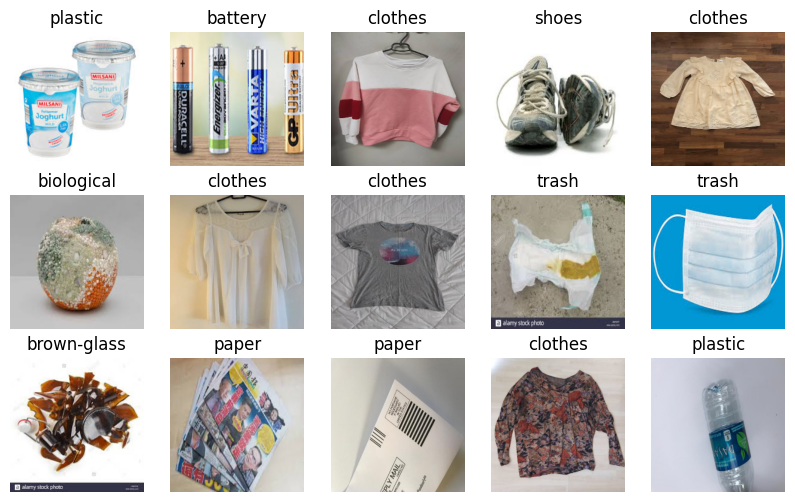

In [11]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [12]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [13]:
import torchvision


# Importa un modelo ResNeXt, por ejemplo, ResNeXt-50-32x4d
resnext = torchvision.models.resnext50_32x4d()
resnext

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [14]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=12, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnext50_32x4d(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(2048, 12)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [15]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

c:\Users\ASUS\anaconda3\envs\IA_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\IA_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 12])

In [16]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [17]:
# model_c = ModelCustom()
# fit(model_c, dataloader, epochs=15)

Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [18]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

c:\Users\ASUS\anaconda3\envs\IA_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.53739 val_acc 0.89602: 100%|██████████| 13/13 [01:31<00:00,  7.04s/it]


Epoch 1/5 loss 0.97009 val_loss 0.53739 acc 0.77219 val_acc 0.89602


val_loss 0.38076 val_acc 0.91744: 100%|██████████| 13/13 [01:19<00:00,  6.09s/it]


Epoch 2/5 loss 0.46418 val_loss 0.38076 acc 0.90711 val_acc 0.91744


val_loss 0.32283 val_acc 0.92795: 100%|██████████| 13/13 [01:18<00:00,  6.05s/it]


Epoch 3/5 loss 0.35735 val_loss 0.32283 acc 0.92201 val_acc 0.92795


val_loss 0.28880 val_acc 0.92705: 100%|██████████| 13/13 [01:18<00:00,  6.05s/it]


Epoch 4/5 loss 0.30702 val_loss 0.28880 acc 0.93141 val_acc 0.92705


val_loss 0.26628 val_acc 0.93554: 100%|██████████| 13/13 [01:18<00:00,  6.05s/it]

Epoch 5/5 loss 0.28063 val_loss 0.26628 acc 0.93200 val_acc 0.93554


Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [19]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 0.17903 val_acc 0.95297: 100%|██████████| 13/13 [03:23<00:00, 15.63s/it]


Epoch 1/5 loss 0.53075 val_loss 0.17903 acc 0.86951 val_acc 0.95297


val_loss 0.12367 val_acc 0.96469: 100%|██████████| 13/13 [02:56<00:00, 13.54s/it]


Epoch 2/5 loss 0.12870 val_loss 0.12367 acc 0.96375 val_acc 0.96469


val_loss 0.11440 val_acc 0.96957: 100%|██████████| 13/13 [03:05<00:00, 14.23s/it]


Epoch 3/5 loss 0.06603 val_loss 0.11440 acc 0.98389 val_acc 0.96957


val_loss 0.10258 val_acc 0.97108: 100%|██████████| 13/13 [03:12<00:00, 14.81s/it]


Epoch 4/5 loss 0.03668 val_loss 0.10258 acc 0.99250 val_acc 0.97108


val_loss 0.10195 val_acc 0.97108: 100%|██████████| 13/13 [03:08<00:00, 14.54s/it]

Epoch 5/5 loss 0.02340 val_loss 0.10195 acc 0.99565 val_acc 0.97108


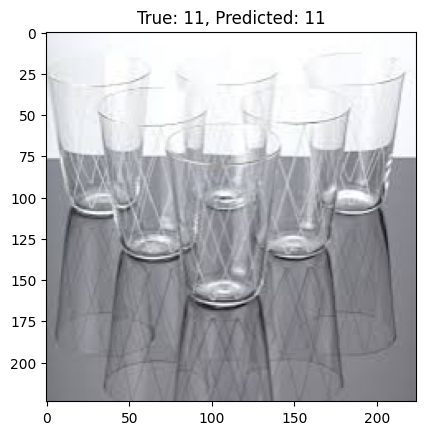

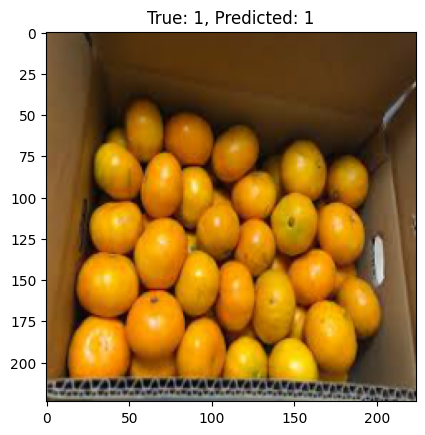

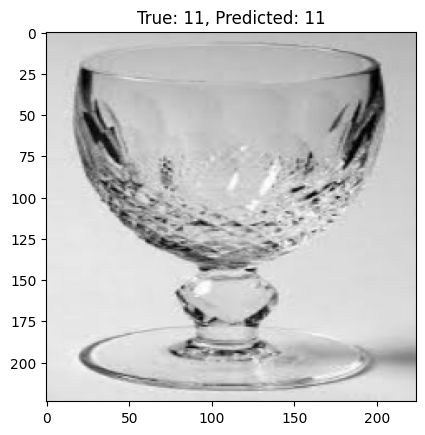

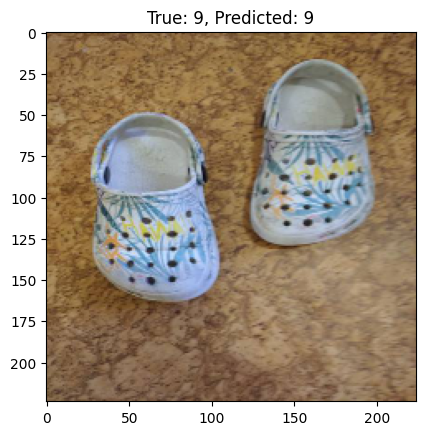

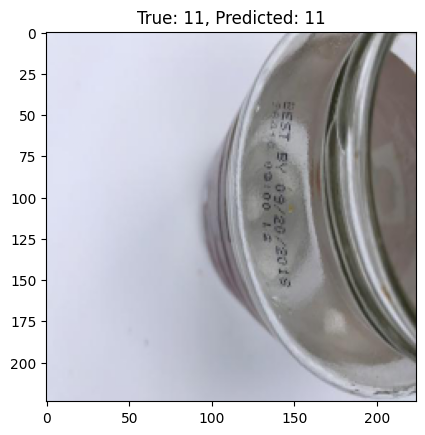

In [25]:
import random
import matplotlib.pyplot as plt

def show_random_predicted_images(model, dataloader, device, num_predictions=5):
    model.eval()
    dataset = dataloader['test'].dataset
    indices = random.sample(range(len(dataset)), num_predictions)

    with torch.no_grad():
        for index in indices:
            X, y = dataset[index]
            X = X.unsqueeze(0).to(device)  # Asegúrate de que X sea un lote de un solo elemento
            y_hat = model(X)
            predicted_label = torch.argmax(y_hat, axis=1).item()

            # Visualizar la imagen junto con la etiqueta real y predicha
            image = X[0].cpu().numpy().transpose(1, 2, 0)
            true_label = y.item()

            plt.imshow(image)
            plt.title(f"True: {true_label}, Predicted: {predicted_label}")
            plt.show()

# Llama a esta función después de entrenar tu modelo
show_random_predicted_images(model_c, dataloader, device, num_predictions=5)

Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [20]:
# model_o = ModelCustom(pretrained=True, freeze=True)
# fit(model_o, dataloader)
# model_o.unfreeze()
# fit(model_o, dataloader, lr=1e-4)

In [21]:
# import random
# import matplotlib.pyplot as plt

# def show_random_predicted_images(model, dataloader, device, num_predictions=5):
#     model.eval()
#     dataset = dataloader['test'].dataset
#     indices = random.sample(range(len(dataset)), num_predictions)

#     with torch.no_grad():
#         for index in indices:
#             X, y = dataset[index]
#             X = X.unsqueeze(0).to(device)  # Asegúrate de que X sea un lote de un solo elemento
#             y_hat = model(X)
#             predicted_label = torch.argmax(y_hat, axis=1).item()

#             # Visualizar la imagen junto con la etiqueta real y predicha
#             image = X[0].cpu().numpy().transpose(1, 2, 0)
#             true_label = y.item()

#             plt.imshow(image)
#             plt.title(f"True: {true_label}, Predicted: {predicted_label}")
#             plt.show()

# # Llama a esta función después de entrenar tu modelo
# show_random_predicted_images(model_o, dataloader, device, num_predictions=5)

Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [22]:
# optimizer = torch.optim.Adam([
#     {'params': model_o.resnet.parameters(), 'lr': 1e-4},
#     {'params': model_o.fc.parameters(), 'lr': 1e-3}
# ])

In [23]:
# from tqdm import tqdm
# import numpy as np

# def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
#     model.to(device)
#     optimizer = optimizer = torch.optim.Adam([{'params': model.resnet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
#     criterion = torch.nn.CrossEntropyLoss()
#     for epoch in range(1, epochs+1):
#         model.train()
#         train_loss, train_acc = [], []
#         bar = tqdm(dataloader['train'])
#         for batch in bar:
#             X, y = batch
#             X, y = X.to(device), y.to(device)
#             optimizer.zero_grad()
#             y_hat = model(X)
#             loss = criterion(y_hat, y)
#             loss.backward()
#             optimizer.step()
#             train_loss.append(loss.item())
#             acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
#             train_acc.append(acc)
#             bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
#         bar = tqdm(dataloader['test'])
#         val_loss, val_acc = [], []
#         model.eval()
#         with torch.no_grad():
#             for batch in bar:
#                 X, y = batch
#                 X, y = X.to(device), y.to(device)
#                 y_hat = model(X)
#                 loss = criterion(y_hat, y)
#                 val_loss.append(loss.item())
#                 acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
#                 val_acc.append(acc)
#                 bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
#         print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [24]:
# model_o = ModelCustom(pretrained=True, freeze=True)
# fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)
# model_o.unfreeze()
# fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.